 # 单机多卡并行
 - 一台机器可以安装多个GPU（1-16）
 - 在训练和预测时，我们将一个小批量计算切分到多个GPU上，来达到加速目的
 - 常用切分方案有：
     - 数据并行（主要关注）
     - 模型并行
     - 通道并行（= 数据 + 模型并行）
     
## 数据并行 vs 模型并行

- 数据并行：将小批量分成n块，每个GPU拿到完整参数计算一部分数据的梯度
    - batch size = 128, 4个GPU，每个GPU计算32
    - 通常性能更好
- 模型并行：将模型分成n块，每个GPU拿到一部分模型，计算它的前向和反向结果
    - 100层ResNet，2个GPU，一个GPU0放50层，另外一个GPU1放剩下的50层
        - GPU0算完50层后，把数据给GPU1接着算。算梯度时，就倒过来
        - BUG：GPU0与GPU1可能不同时运算
        - 主要用途：当batch size为1时，单GPU的内存无法放下模型
    - 通常用于模型大到单GPU放不下
    
## 数据并行

- GPU拿着样本（灰色），从key-value store（给存参数的容器，在CPU）拿回并使用参数（橙色），来计算梯度（绿色），最后把梯度返回给key-value store，在kvs里把4个梯度加起来，保存为更新后的梯度
<img src="./pic/数据并行.PNG" width=300 height=300>
- 好处：计算梯度的时间，每个GPU都差不多，相对来说性能较高


## 总结
- 当一个模型能用单卡计算时，通常使用数据并行拓展到多卡上
- 模型并行则用在超大模型上

# 2. 多GPU的从零开始实现
- 代码实现-LeNet

In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
# 初始化模型参数
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

# 定义模型
def lenet(X, params):
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat

# 交叉熵损失函数
loss = nn.CrossEntropyLoss(reduction='none')

### 向多个设备分发参数

In [3]:
# 分配参数到不同的GPU上
def get_params(params, device):
    new_params = [p.to(device) for p in params]
    for p in new_params:
        p.requires_grad_()    # 对每一个p都要计算梯度
    return new_params    # 返回新的参数

In [4]:
new_params = get_params(params, d2l.try_gpu(0))    # 把放在CPU的参数，放到GPU0上面
print('b1 权重:', new_params[1])
print('b1 梯度:', new_params[1].grad)    # 还没有做计算，所以grad是None

b1 权重: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 梯度: None


- `allreduce`函数将所有向量相加，并将结果广播给所有GPU

In [10]:
# 将非GPU0的梯度，挪到GPU0上，然后相加（因为张量计算，只能在同一个GPU下运行），最后相加得到的结果，再返回给每个GPU
# 假如有4个GPU，data=list of 4
def allreduce(data):
    for i in range(1, len(data)):    # 从GPU1到GPU3（GPU0以外的GPU）
        data[0][:] += data[i].to(data[0].device)    # GPU(i)先复制到GPU0【data[0]】上，然后在与GPU0累计相加
        # [:]会在现有的data的内存中修改，没有[:]的话data会再分配一次内存空间；这样可以提高运行和内存效率
    for i in range(1, len(data)):    # 对于非GPU0，把结果重新接入进去
        data[i][:] = data[0].to(data[i].device)
        
        
data = [torch.ones((1, 2), device=d2l.try_gpu(i)) * (i + 1) for i in range(2)]
# GPU0创建第一个张量：[[1., 1.]]
# GPU1创建第二个张量：[[2., 2.]]
print('allreduce之前：\n', data[0], '\n', data[1])
allreduce(data)
print('allreduce之后：\n', data[0], '\n', data[1]) 

IndexError: list index out of range

## 将一个小批量数据均匀地分布在多个GPU上

In [12]:
data = torch.arange(20).reshape(4, 5)
devices = [torch.device('cuda:0')]
split = nn.parallel.scatter(data, devices)    # 把data均匀的切给每一个GPU
print('input :', data)
print('load into', devices)
print('output:', split)

input : tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
load into [device(type='cuda', index=0)]
output: (tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]], device='cuda:0'),)


In [ ]:
data = torch.arange(20).reshape(4, 5)
devices = [torch.device('cuda:0'), torch.device('cuda:1')]
split = nn.parallel.scatter(data, devices)    # 把data均匀的切给每一个GPU
print('input :', data)
print('load into', devices)
print('output:', split)

In [15]:
#@save
def split_batch(X, y, devices):
    """将X和y拆分到多个设备上"""
    assert X.shape[0] == y.shape[0]    # 判断样本数与label数是否一样
    return (nn.parallel.scatter(X, devices),
            nn.parallel.scatter(y, devices))     # 把data与label均匀的切给每一个GPU

## 在一个小批量上实现多GPU训练

In [14]:
# 小批量的X与y，device_params：所有GPU上的params；devices：有哪些GPU
def train_batch(X, y, device_params, devices, lr):
    X_shards, y_shards = split_batch(X, y, devices)    # 把小批量均匀的分配到GPU上
    # 在每个GPU上分别计算损失，ls是一个list
    ls = [loss(lenet(X_shard, device_W), y_shard).sum()
          for X_shard, y_shard, device_W in zip(       # 每次拿到的是某一个GPU上的X，y与对应的w（w是完整的，x和y是批量的一块？）
              X_shards, y_shards, device_params)]
    for l in ls:  # 反向传播在每个GPU上分别执行
        l.backward()
    # 将每个GPU的所有梯度相加，并将其广播到所有GPU
    with torch.no_grad():
        for i in range(len(device_params[0])):
            allreduce(
                [device_params[c][i].grad
                 for c in range(len(devices))])    # 返回整个小批量完整的梯度
            # allreduce分发的是参数的梯度，而不是参数本身
    # 在每个GPU上分别更新模型参数
    for param in device_params:
        d2l.sgd(param, lr, X.shape[0]) # 在这里，我们使用全尺寸的小批量

## 定义训练函数

In [13]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    # 将模型参数（初始化的params）复制到num_gpus个GPU，这样每个GPU初始拿到的梯度都是一样的
    device_params = [get_params(params, d) for d in devices]
    num_epochs = 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            # 为单个小批量执行多GPU训练
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize()    # 同步一次，保证每个GPU都计算完
        timer.stop()
        # 在GPU0上评估模型
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(
            lambda x: lenet(x, device_params[0]), test_iter, devices[0]),))
    print(f'测试精度：{animator.Y[0][-1]:.2f}，{timer.avg():.1f}秒/轮，'
          f'在{str(devices)}')

## 在单个GPU上运行

测试精度：0.83，2.8秒/轮，在[device(type='cuda', index=0)]


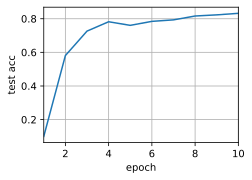

In [16]:
train(num_gpus=1, batch_size=256, lr=0.2)

## 增加为2个GPU

In [ ]:
train(num_gpus=2, batch_size=256, lr=0.2)

### 多GPU训练的速度，可能不会变快：
1. 读data慢
2. GPU增加，但batchsize没变
3. train(num_gpus=2, batch_size=256*2, lr=0.2*1.5)

# 3. 多GPU的简洁实现
- `nn.DataParallel`
    - 在net forward时，会把批量拆分

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [5]:
def resnet18(num_classes, in_channels=1):
    """稍加修改的ResNet-18模型"""
    def resnet_block(in_channels, out_channels, num_residuals,
                     first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(d2l.Residual(in_channels, out_channels,
                                        use_1x1conv=True, strides=2))
            else:
                blk.append(d2l.Residual(out_channels, out_channels))
        return nn.Sequential(*blk)

    # 该模型使用了更小的卷积核、步长和填充，而且删除了最大汇聚层
    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU())
    net.add_module("resnet_block1", resnet_block(
        64, 64, 2, first_block=True))
    net.add_module("resnet_block2", resnet_block(64, 128, 2))
    net.add_module("resnet_block3", resnet_block(128, 256, 2))
    net.add_module("resnet_block4", resnet_block(256, 512, 2))
    net.add_module("global_avg_pool", nn.AdaptiveAvgPool2d((1,1)))
    net.add_module("fc", nn.Sequential(nn.Flatten(),
                                       nn.Linear(512, num_classes)))
    return net


net = resnet18(10)
# 获取GPU列表
devices = d2l.try_all_gpus()
# 我们将在训练代码实现中初始化网络

## 训练

In [6]:
def train(net, num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    
    def init_weights(m):
        if type(m) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(m.weight, std=0.01)
    
    net.apply(init_weights)
    # 在多个GPU上设置模型
    net = nn.DataParallel(net, device_ids=devices) # 将返回的net复制到每一个GPU上
    trainer = torch.optim.SGD(net.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    timer, num_epochs = d2l.Timer(), 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        net.train()
        timer.start()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])    # DataParallel会自动分配部分批量给其他GPU
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        timer.stop()
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(net, test_iter),))
    print(f'测试精度：{animator.Y[0][-1]:.2f}，{timer.avg():.1f}秒/轮，'
          f'在{str(devices)}')

测试精度：0.92，28.0秒/轮，在[device(type='cuda', index=0)]


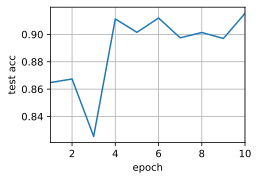

In [7]:
train(net, num_gpus=1, batch_size=256, lr=0.1)
# 因为lr比较大，所以容易抖动。不关注前面一节，只要后面稳定就行

In [ ]:
train(net, num_gpus=2, batch_size=256*2, lr=0.1*2)
# 在数据多样性不足的情况下，无法使用过大的batch size，因为重复过多
# batchsize 大，lr 大
# batchsize 小，lr 小